<a href="https://colab.research.google.com/github/LucaMagini/AgeDetection/blob/main/6Final_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Model

In the previous notebook the best model was **ResNet-50** with an accuracy of *57.23%*.  
So I've decided to continue to perform **hyperparameter tuning** on this model changing the final layers, adding or deleting some regularization or trying some different learning rate values.  

Not to make the notebook too long, here is only the best configuration which returns a very good accuracy considering the type of task and the fact that it's a 8-class classification problem.  

Let's check the model

### Data Preparation

In [ ]:
#Importing the libraries
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model 
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from zipfile import ZipFile
from tabulate import tabulate

In [ ]:
#Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzipping all the datasets
train_augmented_new_path = '/content/drive/MyDrive/Age_Detection_Project/Data/Train_Augmented.zip'
dev_path = '/content/drive/MyDrive/Age_Detection_Project/Data/Dev.zip'
test_path = '/content/drive/MyDrive/Age_Detection_Project/Data/Test.zip'

paths = [test_path, dev_path, train_augmented_new_path]

for path in paths:         
    with ZipFile(path, 'r') as myzip:
        myzip.extractall('../content/{}'.format(path.split('/')[-1].split('.')[0]))
        print('Done unzipping {}'.format(path.split('/')[-1]))

Done unzipping Test.zip
Done unzipping Dev.zip
Done unzipping Train_Augmented.zip


In [ ]:
#Creating the folders
train_augmented_new_folder = '../content/Train_Augmented' 
dev_folder = '../content/Dev'
test_folder = '../content/Test'

In [ ]:
#Creating train, validation and test datasets
batch_size = 256
num_classes = 8
epochs = 30
input_shape = (224, 224, 3)

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_augmented_new_folder,
  validation_split=None,
  subset=None, 
  seed=41, 
  shuffle=True,
  image_size=(224, 224),
  batch_size=batch_size
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  dev_folder,
  validation_split=None,
  subset=None,
  seed=41, 
  shuffle=True,
  image_size=(224, 224),
  batch_size=batch_size
  )

test_dataset = tf.keras.utils.image_dataset_from_directory(
  test_folder,
  validation_split=None,
  subset=None,
  seed=41, 
  shuffle=False,
  image_size=(224, 224),
  batch_size=batch_size
  )

print('Batches for training -->', train_ds.cardinality())
print('Batches for validating -->', val_ds.cardinality())
print('Batches for testing -->', test_dataset.cardinality())

Found 166026 files belonging to 8 classes.
Found 5083 files belonging to 8 classes.
Found 5083 files belonging to 8 classes.
Batches for training --> tf.Tensor(649, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(20, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(20, shape=(), dtype=int64)


In [ ]:
#Defining a function to plot the model results
def plot_model_stats(train_loss, val_loss, train_accuracy, val_accuracy, title):
    fig, ax = plt.subplots(ncols=2, figsize=(15,7))

    ax = ax.ravel()

    ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
    ax[0].plot(val_loss, label='Validation Loss', color = 'orangered', marker='o', markersize=5)

    ax[0].set_xlabel('Epochs', fontsize=14)
    ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

    ax[0].legend(fontsize=14)
    ax[0].tick_params(axis='both', labelsize=12)

    ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
    ax[1].plot(val_accuracy, label='Validation Accuracy', color='orangered', marker='o', markersize=5)

    ax[1].set_xlabel('Epochs', fontsize=14)
    ax[1].set_ylabel('Accuracy', fontsize=14)

    ax[1].legend(fontsize=14)
    ax[1].tick_params(axis='both', labelsize=12)

    fig.suptitle(x=0.5, y=0.94, t=title, fontsize=16)

### Model Creation

In [ ]:
#Importing the ResNet-50 pre-trained model
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape, classes=num_classes)

for layers in ResNet50_model.layers:
    layers.trainable=False

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
#Defining the final layers of the model
resnet50 = Flatten()(ResNet50_model.output)
resnet50 = Dropout(0.5)(resnet50)
resnet50 = Dense(512,activation='relu')(resnet50)
resnet50 = Dropout(0.2)(resnet50)
resnet50 = Dense(128,activation='relu')(resnet50)
resnet50 = Dropout(0.2)(resnet50)
resnet50 = Dense(32,activation='relu')(resnet50)
resnet50 = Dropout(0.5)(resnet50)
resnet50 = Dense(8,activation='softmax')(resnet50)
resnet50_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50)
resnet50_final_model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['sparse_categorical_accuracy'])

In [ ]:
#Training the model 
number_of_epochs = 50
resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=1, mode='min') 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=4, min_lr=0.000002)
callbacklist = [resnet_early_stopping,reduce_lr]
resnet50_history = resnet50_final_model.fit(train_ds, epochs = number_of_epochs ,validation_data = val_ds,callbacks=callbacklist,verbose=1)

Epoch 1/50
649/649 [==============================] - 581s 870ms/step - loss: 1.7197 - sparse_categorical_accuracy: 0.3678 - val_loss: 1.2436 - val_sparse_categorical_accuracy: 0.5465 - lr: 1.0000e-04
Epoch 2/50
649/649 [==============================] - 564s 868ms/step - loss: 1.4238 - sparse_categorical_accuracy: 0.4598 - val_loss: 1.0892 - val_sparse_categorical_accuracy: 0.5810 - lr: 1.0000e-04
Epoch 3/50
649/649 [==============================] - 564s 868ms/step - loss: 1.3007 - sparse_categorical_accuracy: 0.4986 - val_loss: 0.9829 - val_sparse_categorical_accuracy: 0.6002 - lr: 1.0000e-04
Epoch 4/50
649/649 [==============================] - 564s 869ms/step - loss: 1.2087 - sparse_categorical_accuracy: 0.5302 - val_loss: 0.9169 - val_sparse_categorical_accuracy: 0.6341 - lr: 1.0000e-04
Epoch 5/50
649/649 [==============================] - 566s 870ms/step - loss: 1.1322 - sparse_categorical_accuracy: 0.5583 - val_loss: 0.8426 - val_sparse_categorical_accuracy: 0.6671 - lr: 1.0000

In [ ]:
#Saving the train and validation loss and accuracy values from ResNet-50 (final model)
train_loss_resnet50 = resnet50_history.history['loss']
val_loss_resnet50 = resnet50_history.history['val_loss']
train_accuracy_resnet50 = resnet50_history.history['sparse_categorical_accuracy']
val_accuracy_resnet50 = resnet50_history.history['val_sparse_categorical_accuracy']

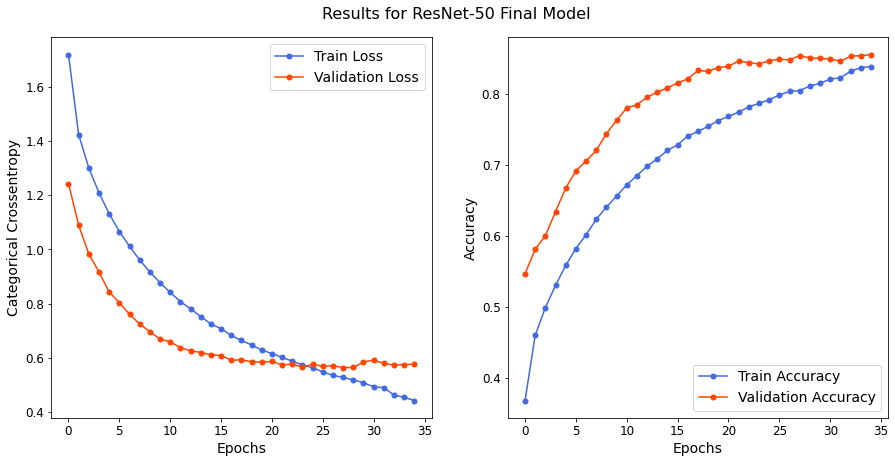

In [ ]:
#Plotting a line chart to visualize the loss and accuracy values by epochs
plot_model_stats(train_loss_resnet50, val_loss_resnet50, train_accuracy_resnet50, val_accuracy_resnet50, 'Results for ResNet-50 Final Model')

In [ ]:
#Accuracy Evaluation
print('\n--------- ResNet-50 ----------\n')
resnet50_acc = round(resnet50_final_model.evaluate(test_dataset, verbose=0)[1] * 100, 2)
print("Model Accuracy: {}%".format(resnet50_acc))


--------- ResNet-50 ----------

Model Accuracy: 85.42%


In [ ]:
#Saving the weights of the model
path = '../content/drive/MyDrive/Age_Detection_Project/Models/resnet50_weights.h5'
resnet50_final_model.save_weights(path, save_format='h5')

In [ ]:
#Creating list of labels
labels = list(np.concatenate([y for x, y in test_dataset], axis=0))

#Creating list of predictions
res50net_pred = resnet50_final_model.predict(test_dataset)
res50net_pred = list(res50net_pred.argmax(axis=-1))

20/20 [==============================] - 19s 924ms/step


In [ ]:
#Creating confusion matrix
conf_matrix = confusion_matrix(labels, res50net_pred, normalize='pred')
conf_matrix

array([[0.95896328, 0.03957784, 0.00589102, 0.00220022, 0.        ,
        0.00218341, 0.00701754, 0.        ],
       [0.02267819, 0.89182058, 0.01988218, 0.00770077, 0.00843882,
        0.00436681, 0.00350877, 0.00340136],
       [0.00863931, 0.02902375, 0.88365243, 0.11991199, 0.03164557,
        0.01528384, 0.01052632, 0.        ],
       [0.00323974, 0.01055409, 0.06848306, 0.77667767, 0.092827  ,
        0.01528384, 0.01754386, 0.00340136],
       [0.00107991, 0.00263852, 0.01104566, 0.06710671, 0.74050633,
        0.04585153, 0.01754386, 0.00680272],
       [0.00107991, 0.01846966, 0.00810015, 0.01210121, 0.08438819,
        0.81877729, 0.09122807, 0.02380952],
       [0.00323974, 0.00527704, 0.00294551, 0.00990099, 0.02531646,
        0.07423581, 0.75789474, 0.05102041],
       [0.00107991, 0.00263852, 0.        , 0.00440044, 0.01687764,
        0.02401747, 0.09473684, 0.91156463]])

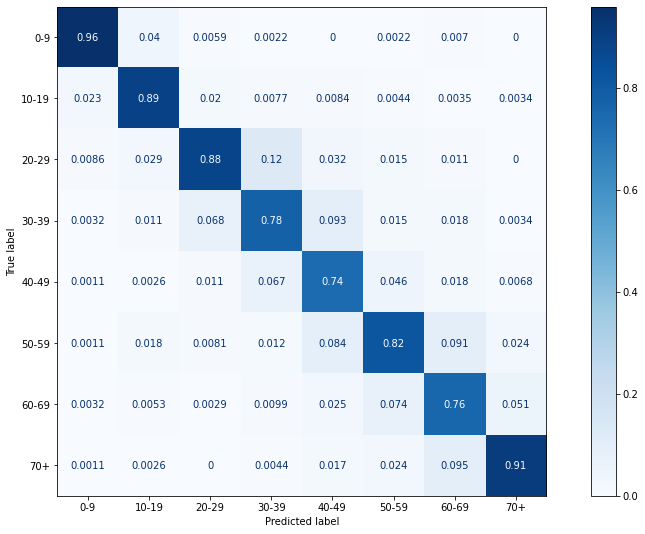

In [ ]:
#Showing confusion matrix 
plot_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=plot_labels)
fig, ax = plt.subplots(figsize=(16,9))

disp.plot(cmap=plt.cm.Blues, ax=ax)

In [ ]:
#Defining a function to compute the 1 class-off accuracy
def one_classoff_acc(labels, predictions):
  val = 0
  for n in range(len(labels)):
    if (predictions[n] >= (labels[n] - 1)) and (predictions[n] <= (labels[n] + 1)):
      val += 1
  return str(round(val * 100 / len(labels), 2))  

In [ ]:
#1 Class-Off Accuracy
print('\n--------- ResNet-50 ----------\n')
acc_oneoff = one_classoff_acc(labels, res50net_pred)
print("Model 1 Class-Off Accuracy: {}%".format(acc_oneoff))


--------- ResNet-50 ----------

Model 1 Class-Off Accuracy: 96.12%


In [ ]:
#Defining function to get percentage string from a number 
def perc(num):
  return str(round(float(num)*100, 2))+'%'

#Building the table of the result
table = [['\033[1m#\033[0m', '\033[1mModel Description\033[0m', '\033[1mTrain Loss\033[0m', '\033[1mVal Loss\033[0m', '\033[1mTrain Acc\033[0m', '\033[1mVal Acc\033[0m', '\033[1mTest Acc\033[0m', '\033[1m1Class-Off Test Acc\033[0m'], 
         ['1', 'RESNET-50 (Final Model)', str(round(train_loss_resnet50[-1], 3)), round(val_loss_resnet50[-1], 3), perc(train_accuracy_resnet50[-1]), perc(val_accuracy_resnet50[-1]), perc(resnet50_acc/100), perc(float(acc_oneoff)/100)]
        ]

#Printing the table
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════╤═════════════════════════╤══════════════╤════════════╤═════════════╤═══════════╤════════════╤═══════════════════════╕
│   # │ Model Description       │   Train Loss │   Val Loss │ Train Acc   │ Val Acc   │ Test Acc   │ 1Class-Off Test Acc   │
╞═════╪═════════════════════════╪══════════════╪════════════╪═════════════╪═══════════╪════════════╪═══════════════════════╡
│   1 │ RESNET-50 (Final Model) │        0.442 │      0.576 │ 83.84%      │ 85.54%    │ 85.42%     │ 96.12%                │
╘═════╧═════════════════════════╧══════════════╧════════════╧═════════════╧═══════════╧════════════╧═══════════════════════╛


### Conclusion

The final model returns an accuracy of **85.42%** and a 1 class-off accuracy of **96.12%** on the test dataset which is a satisfactory result. 

We have computed confusion matrix which is a technique for summarizing the performance of a classification algorithm. Classification accuracy alone can be misleading if you have an unequal number of observation in each class, but calculating a confusion matrix can give you a better idea of what your classification model is getting right and what type of errors it is making.  

In our case the confusion matrix doesn't show any unexpected behaviour: first and last class are the easiest ones and the central classes are the hardest ones to be predicted. This situation is completely normal since differences between central classes are less marked than the others.  

<br/>

***Further steps to try to improve***:  
  *  *Increase Training Images*: In particular images belonging to the most difficult classes to be predicted, classes 3-4-6, as we can see in the confusion matrix 

  *  *Change age ranges of classes*: I wanted to find the best model for that particular age ranges, anyway trying to change this ranges can lead to a better performance

  * *Train a more complex model*: One of the best model for this kind of task is the *EfficientNet-B7* model but a great computational power is needed since it has about 66 millions of parameters and 813 layers